# Choroid Plexus and CSF

## Set Up

### Imports

In [ ]:
from warnings import simplefilter

import pandas as pd

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=DeprecationWarning)
simplefilter(action="ignore", category=FutureWarning)

import re
from pathlib import Path
from pyprocessmacro import Process

import numpy as np
import pyperclip
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from IPython.display import Markdown, HTML, display
from io import StringIO
import matplotlib.pyplot as plt
from collections import defaultdict

from reload_recursive import reload_recursive
import sys
import os
from my_python_utils import smart_title

sys.path.insert(0, "/home/srs-9/Projects/ms_mri/analysis/thalamus/helpers")

import helpers
import utils
import regression_utils as regutils
import my_namespace


#### Reload modules

In [2]:
reload_recursive(regutils)
reload_recursive(helpers)
reload_recursive(utils)
reload_recursive(my_namespace)

# import utils
from utils import zscore
from my_namespace import presentation_cols, colors
# from my_namespace import *

# import regression_utils as regutils

#### Load Data

##### Clinical and Volumes

In [3]:
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/figures_tables/3-CP_CSF_analysis"
)
if not fig_path.exists():
    os.makedirs(fig_path)

data = utils.load_data("/home/srs-9/Projects/ms_mri/analysis/thalamus/results/data.csv")


MS_patients = data["dz_type2"] == "MS"
NONMS_patients = data["dz_type2"] == "!MS"
NIND_patients = data["dz_type5"] == "NIND"
OIND_patients = data["dz_type5"] == "OIND"
RMS_patients = data["dz_type5"] == "RMS"
PMS_patients = data["dz_type5"] == "PMS"

p = "<p style='font-family: Mononoki Nerd Font Mono;line-height: 1.3;font-size: 14px;'>"

#### Functions

In [4]:
def plot_betas(
    coefficients,
    lower_ci,
    upper_ci,
    labels,
    ylabel="ρ (partial correlation)",
    title="Partial correlations between CP and CSF Compartments",
    figsize=(8, 6),
    connect_points=False,
    point_color=colors['grey3'],
    ecolor=colors['grey4'],
    line_color=colors['darkest blue2'],
    fontname="Source Sans 3",
    fig_transparent=False,
    axs_transparent=False
):
    """
    Plot partial correlation coefficients with confidence intervals.
    
    Parameters
    ----------
    coefficients : array-like
        Point estimates (e.g., partial correlation coefficients)
    lower_ci : array-like
        Lower confidence interval bounds
    upper_ci : array-like
        Upper confidence interval bounds
    labels : list of str
        X-axis labels for each point
    ylabel : str, optional
        Y-axis label
    title : str, optional
        Plot title
    figsize : tuple, optional
        Figure size (width, height)
    connect_points : bool, optional
        Whether to draw lines connecting the points
        
    Returns
    -------
    fig, ax : matplotlib Figure and Axes objects
    """
    plt.rcParams['font.family'] = fontname
    # Convert to numpy arrays for easier manipulation
    coefficients = np.array(coefficients)
    lower_ci = np.array(lower_ci)
    upper_ci = np.array(upper_ci)
    
    # Create evenly spaced x values
    x = np.arange(len(coefficients))
    
    # Calculate error bar lengths
    y_lower = coefficients - lower_ci
    y_upper = upper_ci - coefficients
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    if fig_transparent:
        fig.patch.set_alpha(0.0)  # Make figure background transparent
    if axs_transparent:
        ax.patch.set_alpha(0.0)   # Make axes background transparent
    
    # Optionally connect points with a line
    if connect_points:
        ax.plot(x, coefficients, '-', color=line_color, 
                linewidth=2, alpha=0.6, zorder=1)
    
    # Plot error bars and points
    ax.errorbar(
        x,
        coefficients,
        yerr=[y_lower, y_upper],
        fmt='o',
        markersize=10,
        color=point_color,
        ecolor=ecolor,
        capsize=6,
        capthick=2.5,
        linewidth=2.5,
        markeredgewidth=2,
        markeredgecolor='white',
        zorder=2,
    )
    
    # Customize the plot
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=11)
    ax.set_xlabel('Compartment', fontsize=14, fontweight='bold', labelpad=10)
    ax.set_ylabel(ylabel, fontsize=14, fontweight='bold', labelpad=10)
    ax.set_title(title, fontsize=15, fontweight='bold', pad=20)
    
    # Add horizontal line at zero for reference
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    plt.tight_layout()
    
    return fig, ax

In [35]:
test_data = data[MS_patients]

for var in ['brain', 'white', 'grey']:
    test_data[var] = test_data[var] / 1000
    
cols = ['brain', 'cat12_brain', 'white', 'cat12_white', 'grey', 'cat12_grey']
max_width = max(len(outcome) for outcome in cols)


vars = ("brain", "cat12_brain", "WBV")
for vars in [("brain", "cat12_brain", "WBV"), ("white", "cat12_wm", "WMV"), ("grey", "cat12_gm", "GMV"),
             ("CP", "LV", "CPLV")]:
    print(f"{vars[2]}\n-----------")
    print(f"{vars[0]:<{max_width+1}}: {test_data[vars[0]].mean():0.2f} ± {test_data[vars[0]].std():0.2f}")
    print(f"{vars[1]:<{max_width+1}}: {test_data[vars[1]].mean():0.2f} ± {test_data[vars[1]].std():0.2f}")
    
    tmp_data = test_data[list(vars[:2])].dropna()
    slope, intercept, r, p, se = stats.linregress(tmp_data[vars[0]], tmp_data[vars[1]])
    pearsonr = stats.pearsonr(tmp_data[vars[0]], tmp_data[vars[1]])
    print(f"{'compare':<{max_width+1}}: ρ={pearsonr.statistic:0.2f}, p={pearsonr.pvalue:0.2}, R2={r**2:0.2f}")
    print("\n")

WBV
-----------
brain       : 1406.87 ± 81.82
cat12_brain : 1097.16 ± 119.01
compare     : ρ=0.41, p=1.3e-20, R2=0.17


WMV
-----------
white       : 654.42 ± 38.82
cat12_wm    : 612.50 ± 64.42
compare     : ρ=0.35, p=7.1e-15, R2=0.12


GMV
-----------
grey        : 752.45 ± 54.41
cat12_gm    : 484.66 ± 61.96
compare     : ρ=0.14, p=0.0022, R2=0.02


CPLV
-----------
CP          : 1718.35 ± 511.21
LV          : 19454.91 ± 14852.40
compare     : ρ=0.55, p=6.2e-39, R2=0.31




In [33]:
vars[:2]

('brain', 'cat12_brain')

In [34]:
test_data[list(vars[:2])]

,brain,cat12_brain
subid,,
1001,1449.155250,1116.567670
1002,1679.759374,1193.294062
1003,1323.687499,1064.248653
1004,1424.543450,926.461316
1005,1332.911461,947.090337
...,...,...
3016,1351.528843,880.102122
3017,1480.297689,1270.275260
3021,1313.727691,1003.723649


In [9]:
test_data = pd.read_csv("/home/srs-9/Projects/ms_mri/data/Clinical_Data_All_updated.csv")

slope, intercept, r, p, se = stats.linregress(test_data['brain'], test_data['cat12_brain'])
pearsonr = stats.pearsonr(test_data['brain'], test_data['cat12_brain'])
print(f"WBV: ρ={pearsonr.statistic:0.2f}, R2={r**2:0.2f}, p={pearsonr.pvalue:0.2}")

slope, intercept, r, p, se = stats.linregress(test_data['white'], test_data['cat12_wm'])
pearsonr = stats.pearsonr(test_data['white'], test_data['cat12_wm'])
print(f"WMV: ρ={pearsonr.statistic:0.2f}, R2={r**2:0.2f}, p={pearsonr.pvalue:0.2}")

slope, intercept, r, p, se = stats.linregress(test_data['grey'], test_data['cat12_gm'])
pearsonr = stats.pearsonr(test_data['grey'], test_data['cat12_gm'])
print(f"GMV: ρ={pearsonr.statistic:0.2f}, R2={r**2:0.2f}, p={pearsonr.pvalue:0.2}")

WBV: ρ=0.40, R2=0.16, p=2.9e-23
WMV: ρ=0.36, R2=0.13, p=1.4e-18
GMV: ρ=0.11, R2=0.01, p=0.0084


## Regressions on CSF volumes

Peripheral CSF segmentation was obtained starting from the `FAST` CSF segmentation, then subtracting the lateral, third, and fourth ventricles and also label 24 from Freesurfer's `aseg.auto_noCCseg` segmentation (technically Fastsurfer's)

### Does CP drive central atrophy?

Previous analysis showed that CP is very strongly associated with LV; in fact, of all the variables I'm looking at, LV is the one with the strongest association with CP. Both CP and LV enlarge in MS. We know that LV enlargement can be indicative of a few different pathologic processes.

1. Overproduction of CSF
2. Atrophy
3. CSF obstruction

Also, atrophy associated with ventricular enlargement could be global or central. 

#### CP volume and CSF compartment expansion

**Does CP predict the volume of the third ventricle, fourth ventricle, and peripheral CSF, and which ones is it most strongly associated with?**

- CP has the strongest relationship with the LV's, then aseg label 24\*, then the third ventricle, and finally the fourth ventricle. 

\**Freesurfer's aseg segmentation has a label 24 called "CSF" which is a misnomer because it is actually pretty small and located at some periaqueductal/interthalamic CSF pocket.*

- Call it interthalamic CSF

In [ ]:
stats.vonmises_line

model_data = zscore(data[MS_patients], skip_vars=["PRL"])

outcomes = ["LV_log", "interCSF_log", "thirdV_log", "fourthV_log", "periCSF_log"]
predictors = ["CP", "t2lv_log", "THALAMUS_1", "brain", "PRL"]
covariates = ["age", "Female", "tiv"]

_, results, check = regutils.run_regressions(
    model_data, outcomes, predictors, covariates=covariates
)

# for predictor, result in results.items():
for predictor in ["CP", "t2lv_log"]:
    result = results[predictor]
    formula = regutils.formula_string("outcome", predictor, covariates)
    display_order = result["coef"].apply(np.abs).sort_values(ascending=False).index
    display(Markdown(f"```R\n{formula}\n```\n"))
    display(
        Markdown(
            regutils.present_model(
                result, cols=presentation_cols, inds=display_order
            ).to_markdown()
        )
    )

```R
outcome ~ CP + age + Female + tiv
```


| outcome      |   coef |    pval |   p_fdr |     se | ci              |   R2 |
|:-------------|-------:|--------:|--------:|-------:|:----------------|-----:|
| LV_log       | 0.6457 | 4.4e-85 | 2.2e-84 | 0.033  | [0.581, 0.71]   | 0.57 |
| interCSF_log | 0.4676 | 7.3e-26 | 1.8e-25 | 0.0445 | [0.38, 0.555]   | 0.27 |
| thirdV_log   | 0.4264 | 7.5e-24 | 1.3e-23 | 0.0424 | [0.343, 0.509]  | 0.35 |
| fourthV_log  | 0.23   | 4.8e-06 | 6e-06   | 0.0503 | [0.131, 0.329]  | 0.14 |
| periCSF_log  | 0.1523 | 1.7e-05 | 1.7e-05 | 0.0354 | [0.0828, 0.222] | 0.57 |

```R
outcome ~ t2lv_log + age + Female + tiv
```


| outcome      |   coef |    pval |   p_fdr |     se | ci               |   R2 |
|:-------------|-------:|--------:|--------:|-------:|:-----------------|-----:|
| LV_log       | 0.3992 | 2.5e-13 | 1.3e-12 | 0.0545 | [0.292, 0.506]   | 0.38 |
| thirdV_log   | 0.3312 | 7.5e-09 | 1.9e-08 | 0.0573 | [0.219, 0.443]   | 0.31 |
| interCSF_log | 0.2797 | 1.3e-05 | 2.2e-05 | 0.0642 | [0.154, 0.406]   | 0.17 |
| fourthV_log  | 0.1539 | 0.0024  | 0.003   | 0.0507 | [0.0544, 0.253]  | 0.12 |
| periCSF_log  | 0.0407 | 0.28    | 0.28    | 0.0377 | [-0.0332, 0.115] | 0.55 |

##### Plot the betas of CP wrt to CSF compartments

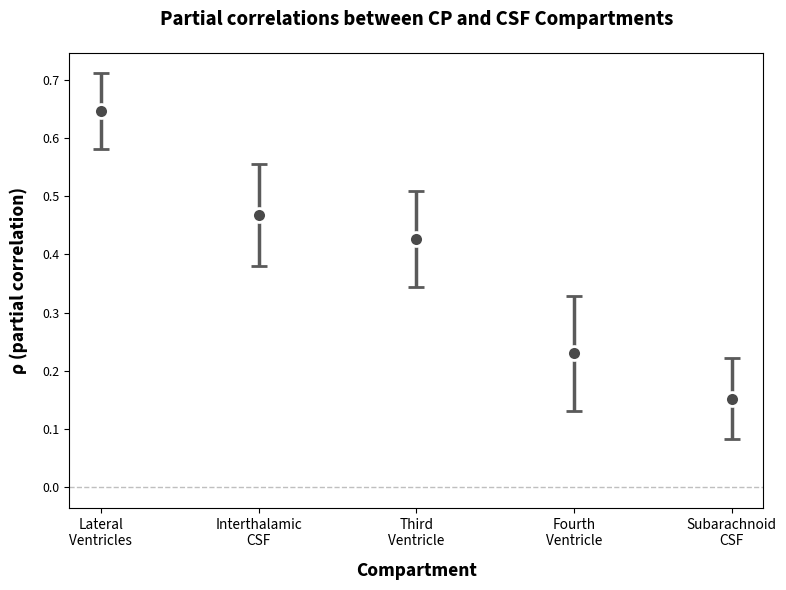

In [ ]:
plot_data = results['CP']

save_name = "Partial correlation plot CP and CSF (with line).png"
fig, ax = plot_betas(
    coefficients=plot_data['coef'],
    lower_ci=plot_data['llci'],
    upper_ci=plot_data['ulci'],
    labels=['Lateral\nVentricles', 'Interthalamic\nCSF', 
            'Third\nVentricle', 'Fourth\nVentricle', 'Subarachnoid\nCSF'],
    connect_points=True,
    fig_transparent=False,
    axs_transparent=False
)
fig.savefig(fig_path / save_name, dpi=300, bbox_inches='tight', transparent=False)
plt.close()

save_name = "Partial correlation plot CP and CSF (no line).png"
fig, ax = plot_betas(
    coefficients=plot_data['coef'],
    lower_ci=plot_data['llci'],
    upper_ci=plot_data['ulci'],
    labels=['Lateral\nVentricles', 'Interthalamic\nCSF', 
            'Third\nVentricle', 'Fourth\nVentricle', 'Subarachnoid\nCSF'],
    connect_points=False,
    fig_transparent=False,
    axs_transparent=False
)
fig.savefig(fig_path / save_name, dpi=300, bbox_inches='tight', transparent=False)

##### CP predicts CSF expansion after controlling for atrophy

After controlling for both brain and WTV, CP retained significant associations with all but the subarachnoid (most peripheral) CSF compartment. T2LV only retained its relationship to LV.

In [ ]:
covariates = ["THALAMUS_1", "brain", "age", "Female", "tiv"]
outcomes = ["LV_log", "interCSF_log", "thirdV_log", "fourthV_log", "periCSF_log"]

predictors = ["CP", "t2lv_log"]
_, results, _ = regutils.run_regressions(
    model_data, outcomes, predictors, covariates=covariates
)

for predictor in ["CP", "t2lv_log"]:
    result = results[predictor]
    display(
        Markdown(
            f"**Effect of {predictor} on outcomes after accounting for brain and THALAMUS_1 as well**"
        )
    )
    formula = regutils.formula_string("outcome", predictor, covariates)
    display(Markdown(f"`{formula}`"))
    display(
        Markdown(regutils.present_model(result, presentation_cols).to_markdown())
    )

**Effect of CP on outcomes after accounting for brain and THALAMUS_1 as well**

`outcome ~ CP + THALAMUS_1 + brain + age + Female + tiv`

| outcome      |   coef |    pval |   p_fdr |     se | ci               |   R2 |
|:-------------|-------:|--------:|--------:|-------:|:-----------------|-----:|
| LV_log       | 0.4816 | 3.3e-40 | 1.6e-39 | 0.0363 | [0.411, 0.553]   | 0.67 |
| interCSF_log | 0.2857 | 1.4e-09 | 3.5e-09 | 0.0472 | [0.193, 0.378]   | 0.37 |
| thirdV_log   | 0.2205 | 1.1e-07 | 1.8e-07 | 0.0415 | [0.139, 0.302]   | 0.48 |
| fourthV_log  | 0.1328 | 0.019   | 0.024   | 0.0568 | [0.0214, 0.244]  | 0.17 |
| periCSF_log  | 0.0528 | 0.15    | 0.15    | 0.0366 | [-0.0188, 0.125] | 0.61 |

**Effect of t2lv_log on outcomes after accounting for brain and THALAMUS_1 as well**

`outcome ~ t2lv_log + THALAMUS_1 + brain + age + Female + tiv`

| outcome      |    coef |   pval |   p_fdr |     se | ci               |   R2 |
|:-------------|--------:|-------:|--------:|-------:|:-----------------|-----:|
| LV_log       |  0.1442 | 0.0078 |   0.039 | 0.0542 | [0.038, 0.25]    | 0.54 |
| interCSF_log |  0.0336 | 0.57   |   0.57  | 0.0592 | [-0.0825, 0.15]  | 0.32 |
| thirdV_log   |  0.0874 | 0.11   |   0.28  | 0.0552 | [-0.0207, 0.196] | 0.46 |
| fourthV_log  |  0.0549 | 0.33   |   0.41  | 0.0565 | [-0.0559, 0.166] | 0.16 |
| periCSF_log  | -0.0494 | 0.24   |   0.4   | 0.0421 | [-0.132, 0.0332] | 0.61 |

#### CSF compartment volumes predict PRL count

In [8]:
model_data = zscore(data[MS_patients], skip_vars=["PRL"])
predictors = ["LV_log", "interCSF_log", "thirdV_log", "fourthV_log", "periCSF_log"]
outcome = "PRL"

test_covariates = {
    "basic": ["age", "Female", "tiv"],
    "add CP": ["CP", "age", "Female", "tiv"],
    "add CP and t2lv": ["CP", "t2lv_log", "age", "Female", "tiv"],
}
results = {}
for model_name, covariates in test_covariates.items():
    results[model_name], _, _ = regutils.run_regressions(
        model_data, outcome, predictors, covariates=covariates, regression_model="GLM"
    )


for name, result in results.items():
    covariates = test_covariates[name]
    formula = regutils.formula_string(outcome, "*predictor*", covariates)
    display_order = result["coef"].apply(np.abs).sort_values(ascending=False).index
    display(Markdown(f"```R\n{formula}\n```\n"))
    display(
        Markdown(
            regutils.present_model(
                result, cols=presentation_cols, inds=display_order
            ).to_markdown()
        )
    )

```R
PRL ~ *predictor* + age + Female + tiv
```


| predictor    |   coef |    pval |   p_fdr |     se | ci             |   R2 |
|:-------------|-------:|--------:|--------:|-------:|:---------------|-----:|
| periCSF_log  | 0.5146 | 0.00013 | 0.00017 | 0.1348 | [0.25, 0.779]  | 0.29 |
| thirdV_log   | 0.4192 | 7.8e-07 | 2.8e-06 | 0.0848 | [0.253, 0.585] | 0.31 |
| LV_log       | 0.4066 | 1.1e-06 | 2.8e-06 | 0.0835 | [0.243, 0.57]  | 0.3  |
| interCSF_log | 0.3253 | 2.2e-05 | 3.7e-05 | 0.0767 | [0.175, 0.476] | 0.28 |
| fourthV_log  | 0.2977 | 0.00037 | 0.00037 | 0.0836 | [0.134, 0.462] | 0.28 |

```R
PRL ~ *predictor* + CP + age + Female + tiv
```


| predictor    |   coef |   pval |   p_fdr |     se | ci               |   R2 |
|:-------------|-------:|-------:|--------:|-------:|:-----------------|-----:|
| periCSF_log  | 0.4013 | 0.002  |   0.01  | 0.1301 | [0.146, 0.656]   | 0.36 |
| thirdV_log   | 0.2793 | 0.0056 |   0.014 | 0.1008 | [0.0819, 0.477]  | 0.35 |
| fourthV_log  | 0.2125 | 0.0084 |   0.014 | 0.0806 | [0.0545, 0.371]  | 0.34 |
| LV_log       | 0.196  | 0.099  |   0.099 | 0.1189 | [-0.0371, 0.429] | 0.33 |
| interCSF_log | 0.1837 | 0.031  |   0.038 | 0.085  | [0.0172, 0.35]   | 0.34 |

```R
PRL ~ *predictor* + CP + t2lv_log + age + Female + tiv
```


| predictor    |   coef |    pval |   p_fdr |     se | ci               |   R2 |
|:-------------|-------:|--------:|--------:|-------:|:-----------------|-----:|
| periCSF_log  | 0.3954 | 0.00097 |  0.0048 | 0.1198 | [0.16, 0.63]     | 0.42 |
| fourthV_log  | 0.1782 | 0.034   |  0.084  | 0.0839 | [0.0138, 0.343]  | 0.39 |
| thirdV_log   | 0.1651 | 0.088   |  0.13   | 0.0969 | [-0.0248, 0.355] | 0.39 |
| interCSF_log | 0.1337 | 0.1     |  0.13   | 0.0814 | [-0.0258, 0.293] | 0.39 |
| LV_log       | 0.0522 | 0.66    |  0.66   | 0.1204 | [-0.184, 0.288]  | 0.38 |

##### Plot the betas of CSF compartments wrt to PRL

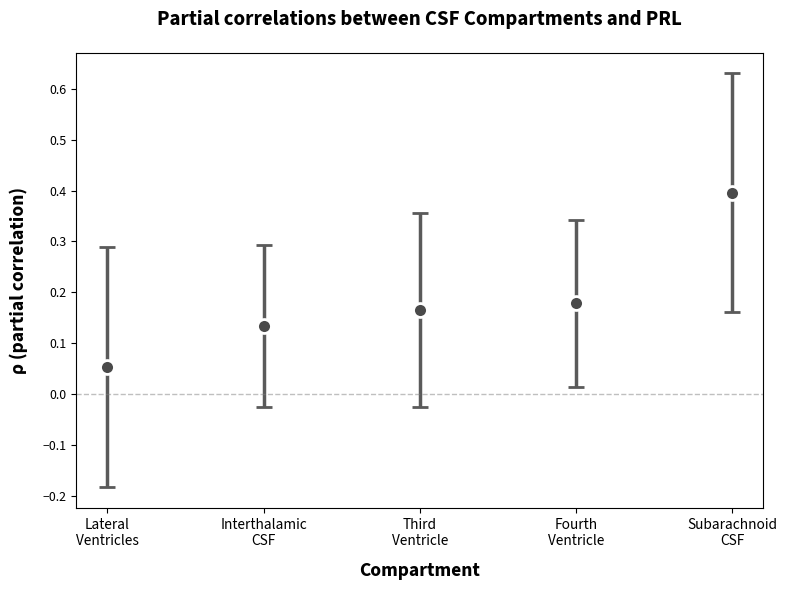

In [11]:
plot_data = results['add CP and t2lv']
fig, ax = plot_betas(
    coefficients=plot_data['coef'],
    lower_ci=plot_data['llci'],
    upper_ci=plot_data['ulci'],
    title="Partial correlations between CSF Compartments and PRL",
    labels=['Lateral\nVentricles', 'Interthalamic\nCSF', 
            'Third\nVentricle', 'Fourth\nVentricle', 'Subarachnoid\nCSF'],
    connect_points=False,
    fig_transparent=False,
    axs_transparent=False
)

CP predicts these compartment volumes after controlling for brain and thalamus, but t2lv does not

#### Sanity check on peripheral CSF

The following is more of a sanity check. If all the CSF volumes are defined properly, particulary peripheral CSF, we'd expect thalamic volume to be related more to the central CSF compartments and for brain volume to be related more to the peripheral CSF volume. This is borne out. Peripheral CSF has a much stronger relationship to WBV and LV has a much stronger relationship to thalamus

In [24]:
model_data_z = zscore(data[MS_patients], skip_vars=["PRL"])

rename_index = {"brain": "**brain**", "THALAMUS_1": "**THALAMUS_1**"}

test_outcomes = ["LV_log", "thirdV_log", "fourthV_log", "periCSF"]
all_results = defaultdict(dict)
all_models = defaultdict(dict)
all_formulas = defaultdict(dict)
for outcome in test_outcomes:
    formula_list = {
        "brain": f"{outcome} ~ brain + age + Female + tiv",
        "thalamus": f"{outcome} ~ THALAMUS_1 + age + Female + tiv",
        "brain+thalamus": f"{outcome} ~ brain + THALAMUS_1 + age + Female + tiv",
    }

    all_results[outcome], all_models[outcome], all_formulas[outcome] = (
        regutils.run_regressions3(
            model_data_z, formula_list.values(), model_names=formula_list.keys()
        )
    )
    
views = [("periCSF", "brain+thalamus"), ("LV_log", "brain+thalamus")]
for outcome, model_name in views:
    display(Markdown(f"##### {outcome}"))
    results = all_results[outcome]
    formulas = all_formulas[outcome]
    model = results[model_name]
    formula = formulas[model_name]

    display(Markdown(f"{model_name}"))
    display(Markdown(f"`{formula}`"))
    display(
        Markdown(
            regutils.present_model(
                model, presentation_cols, rename_index=rename_index
            ).to_markdown()
            + "\n\n"
        )
    )
note = "*Note: brain has a significant association with LV_log before controlling for THALAMUS_1*"
display(Markdown(note))

##### periCSF

brain+thalamus

`periCSF ~ brain + THALAMUS_1 + age + Female + tiv`

|                |    coef |     pval |     se | ci                 |   R2 |
|:---------------|--------:|---------:|-------:|:-------------------|-----:|
| Intercept      | -0.1526 | 0.04     | 0.0744 | [-0.298, -0.00681] | 0.62 |
| Female[T.1]    |  0.1985 | 0.02     | 0.085  | [0.0319, 0.365]    | 0.62 |
| **brain**      | -0.2327 | 7.2e-11  | 0.0357 | [-0.303, -0.163]   | 0.62 |
| **THALAMUS_1** | -0.1109 | 0.013    | 0.0445 | [-0.198, -0.0237]  | 0.62 |
| age            |  0.0609 | 0.074    | 0.0341 | [-0.00597, 0.128]  | 0.62 |
| tiv            |  0.8337 | 4.1e-109 | 0.0376 | [0.76, 0.907]      | 0.62 |



##### LV_log

brain+thalamus

`LV_log ~ brain + THALAMUS_1 + age + Female + tiv`

|                |    coef |    pval |     se | ci                |   R2 |
|:---------------|--------:|--------:|-------:|:------------------|-----:|
| Intercept      | -0.0549 | 0.46    | 0.0743 | [-0.201, 0.0908]  | 0.52 |
| Female[T.1]    |  0.073  | 0.42    | 0.0901 | [-0.104, 0.25]    | 0.52 |
| **brain**      | -0.0151 | 0.72    | 0.0426 | [-0.0987, 0.0685] | 0.52 |
| **THALAMUS_1** | -0.6317 | 8.7e-59 | 0.0391 | [-0.708, -0.555]  | 0.52 |
| age            |  0.2105 | 1.3e-09 | 0.0347 | [0.142, 0.279]    | 0.52 |
| tiv            |  0.4906 | 2.2e-29 | 0.0436 | [0.405, 0.576]    | 0.52 |



*Note: brain has a significant association with LV_log before controlling for THALAMUS_1*

### Central CSF Expansion

Does the relationship between CP and LV volumes represent a global process whereby CP influences overall atrophy or CSF hydrodynamics, or is CP causing regional changes? With the degree of preferential central expansion defined as the central CSF ratio (CCR):

$CCR = LV / periCSF$

#### CP and CCR

**CP is associated with increasing CCR, beyond what is predicted by brain or thalamus volumes.**

Cortical thickness has inverse association with CCR, indicating that atrophy occurs quicker centrally than peripherally in general

In [40]:
model_data_z = zscore(data[MS_patients], skip_vars=["PRL"])
outcome = "CCR2_log"

exog_list = {
    "CP": ["CP"],
    "THALAMUS_1": ["THALAMUS_1"],
    "cortical thickness": ["cortical_thickness"],
    "CP, THALAMUS_1": ["CP", "THALAMUS_1"],
    "CP, cortical thickness": ["CP", "cortical_thickness"],
    "CP, brain": ["CP", "brain"],
    "brain": ["brain"],
    "brain, thalamus": ["brain", "THALAMUS_1"],
    "CP, brain, thalamus": ["CP", "brain", "THALAMUS_1"],
    "THALAMUS_1, cortical thickness": ["THALAMUS_1", "cortical_thickness"],
    "CP, THALAMUS_1, cortical thickness": ["CP", "THALAMUS_1", "cortical_thickness"],
}
covariates = ["age", "Female", "tiv"]

results, models, formulas = regutils.run_regressions2(
    model_data_z,
    outcome,
    exog_list.values(),
    model_names=exog_list.keys(),
    covariates=covariates,
)

copy_text = ""
for model_name, model, formula in zip(
    results.keys(), results.values(), formulas.values()
):
    copy_text += f"#### {smart_title(model_name)}\n\n"
    copy_text += f"```R\n{formula}\n```\n\n"
    copy_text += regutils.present_model(
                model,
                presentation_cols,
                exclude_inds=["Intercept", "age", "Female[T.1]", "tiv"],
            ).to_markdown()
    copy_text += "\n\n"
    
    display(Markdown(f"#### {smart_title(model_name)}"))
    # display(Markdown(f"`{formula}`"))
    display(Markdown(f"```R\n{formula}\n```\n"))
    display(
        Markdown(
            regutils.present_model(
                model,
                presentation_cols,
                exclude_inds=["Intercept", "age", "Female[T.1]", "tiv"],
            ).to_markdown()
        )
    )
    # display(Markdown("---"))

#### CP

```R
CCR2_log ~ CP + age + Female + tiv
```


|    |   coef |    pval |     se | ci             |   R2 |
|:---|-------:|--------:|-------:|:---------------|-----:|
| CP | 0.6355 | 9.5e-75 | 0.0347 | [0.567, 0.704] | 0.51 |

#### THALAMUS_1

```R
CCR2_log ~ THALAMUS_1 + age + Female + tiv
```


|            |    coef |   pval |     se | ci               |   R2 |
|:-----------|--------:|-------:|-------:|:-----------------|-----:|
| THALAMUS_1 | -0.6295 |  8e-66 | 0.0367 | [-0.701, -0.557] | 0.47 |

#### Cortical Thickness

```R
CCR2_log ~ cortical_thickness + age + Female + tiv
```


|                    |    coef |    pval |     se | ci               |   R2 |
|:-------------------|--------:|--------:|-------:|:-----------------|-----:|
| cortical_thickness | -0.4595 | 5.3e-28 | 0.0419 | [-0.542, -0.377] | 0.35 |

#### CP, THALAMUS_1

```R
CCR2_log ~ CP + THALAMUS_1 + age + Female + tiv
```


|            |    coef |    pval |     se | ci               |   R2 |
|:-----------|--------:|--------:|-------:|:-----------------|-----:|
| CP         |  0.4635 | 1.4e-34 | 0.0378 | [0.389, 0.538]   | 0.61 |
| THALAMUS_1 | -0.4109 | 2.7e-22 | 0.0423 | [-0.494, -0.328] | 0.61 |

#### CP, Cortical Thickness

```R
CCR2_log ~ CP + cortical_thickness + age + Female + tiv
```


|                    |    coef |    pval |     se | ci              |   R2 |
|:-------------------|--------:|--------:|-------:|:----------------|-----:|
| CP                 |  0.5467 | 5.3e-47 | 0.038  | [0.472, 0.621]  | 0.56 |
| cortical_thickness | -0.2735 | 2.8e-12 | 0.0391 | [-0.35, -0.197] | 0.56 |

#### CP, Brain

```R
CCR2_log ~ CP + brain + age + Female + tiv
```


|       |   coef |    pval |     se | ci               |   R2 |
|:------|-------:|--------:|-------:|:-----------------|-----:|
| CP    |  0.629 | 3.3e-59 | 0.0388 | [0.553, 0.705]   | 0.51 |
| brain | -0.022 | 0.59    | 0.0408 | [-0.102, 0.0581] | 0.51 |

#### Brain

```R
CCR2_log ~ brain + age + Female + tiv
```


|       |   coef |    pval |     se | ci               |   R2 |
|:------|-------:|--------:|-------:|:-----------------|-----:|
| brain | -0.216 | 8.4e-06 | 0.0485 | [-0.311, -0.121] | 0.23 |

#### Brain, Thalamus

```R
CCR2_log ~ brain + THALAMUS_1 + age + Female + tiv
```


|            |    coef |    pval |     se | ci               |   R2 |
|:-----------|--------:|--------:|-------:|:-----------------|-----:|
| brain      |  0.0185 | 0.68    | 0.0453 | [-0.0702, 0.107] | 0.47 |
| THALAMUS_1 | -0.6368 | 1.4e-52 | 0.0417 | [-0.719, -0.555] | 0.47 |

#### CP, Brain, Thalamus

```R
CCR2_log ~ CP + brain + THALAMUS_1 + age + Female + tiv
```


|            |    coef |    pval |     se | ci               |   R2 |
|:-----------|--------:|--------:|-------:|:-----------------|-----:|
| CP         |  0.4786 | 3.7e-35 | 0.0387 | [0.403, 0.554]   | 0.61 |
| brain      |  0.0941 | 0.012   | 0.0376 | [0.0204, 0.168]  | 0.61 |
| THALAMUS_1 | -0.4411 | 6.4e-24 | 0.0437 | [-0.527, -0.355] | 0.61 |

#### THALAMUS_1, Cortical Thickness

```R
CCR2_log ~ THALAMUS_1 + cortical_thickness + age + Female + tiv
```


|                    |    coef |    pval |     se | ci                |   R2 |
|:-------------------|--------:|--------:|-------:|:------------------|-----:|
| THALAMUS_1         | -0.5452 | 2.8e-27 | 0.0504 | [-0.644, -0.446]  | 0.48 |
| cortical_thickness | -0.1294 | 0.007   | 0.048  | [-0.224, -0.0353] | 0.48 |

#### CP, THALAMUS_1, Cortical Thickness

```R
CCR2_log ~ CP + THALAMUS_1 + cortical_thickness + age + Female + tiv
```


|                    |    coef |    pval |     se | ci                 |   R2 |
|:-------------------|--------:|--------:|-------:|:-------------------|-----:|
| CP                 |  0.4578 | 1.8e-33 | 0.038  | [0.383, 0.532]     | 0.61 |
| THALAMUS_1         | -0.3563 | 1.4e-13 | 0.0482 | [-0.451, -0.262]   | 0.61 |
| cortical_thickness | -0.088  | 0.028   | 0.04   | [-0.166, -0.00954] | 0.61 |

In [41]:
pyperclip.copy(copy_text)

#### T2LV and CCR

In [12]:
model_data_z = zscore(data[MS_patients], skip_vars=["PRL"])
outcome = "CCR2_log"

exog_list = {
    "t2lv_log": ["t2lv_log"],
    "THALAMUS_1": ["THALAMUS_1"],
    "cortical thickness": ["cortical_thickness"],
    "brain": ["brain"],
    "t2lv_log, THALAMUS_1": ["t2lv_log", "THALAMUS_1"],
    "t2lv_log, cortical thickness": ["t2lv_log", "cortical_thickness"],
    "t2lv_log, brain": ["t2lv_log", "brain"],
    "THALAMUS_1, cortical thickness": ["THALAMUS_1", "cortical_thickness"],
    "t2lv_log, THALAMUS_1, cortical thickness": ["t2lv_log", "THALAMUS_1", "cortical_thickness"],
}
covariates = ["age", "Female", "tiv"]

results, models, formulas = regutils.run_regressions2(
    model_data_z,
    outcome,
    exog_list.values(),
    model_names=exog_list.keys(),
    covariates=covariates,
)

for model_name, model, formula in zip(
    results.keys(), results.values(), formulas.values()
):
    display(Markdown(f"#### {smart_title(model_name)}"))
    # display(Markdown(f"`{formula}`"))
    display(Markdown(f"```R\n{formula}\n```\n"))
    display(
        Markdown(
            regutils.present_model(
                model,
                presentation_cols,
                exclude_inds=["Intercept", "age", "Female[T.1]", "tiv"],
            ).to_markdown()
        )
    )
    # display(Markdown("---"))

#### T2LV

```R
CCR2_log ~ t2lv_log + age + Female + tiv
```


|          |   coef |   pval |     se | ci             |   R2 |
|:---------|-------:|-------:|-------:|:---------------|-----:|
| t2lv_log | 0.4053 |  8e-13 | 0.0566 | [0.294, 0.516] | 0.34 |

#### THALAMUS_1

```R
CCR2_log ~ THALAMUS_1 + age + Female + tiv
```


|            |    coef |   pval |     se | ci               |   R2 |
|:-----------|--------:|-------:|-------:|:-----------------|-----:|
| THALAMUS_1 | -0.6295 |  8e-66 | 0.0367 | [-0.701, -0.557] | 0.47 |

#### Cortical Thickness

```R
CCR2_log ~ cortical_thickness + age + Female + tiv
```


|                    |    coef |    pval |     se | ci               |   R2 |
|:-------------------|--------:|--------:|-------:|:-----------------|-----:|
| cortical_thickness | -0.4595 | 5.3e-28 | 0.0419 | [-0.542, -0.377] | 0.35 |

#### Brain

```R
CCR2_log ~ brain + age + Female + tiv
```


|       |   coef |    pval |     se | ci               |   R2 |
|:------|-------:|--------:|-------:|:-----------------|-----:|
| brain | -0.216 | 8.4e-06 | 0.0485 | [-0.311, -0.121] | 0.23 |

#### T2LV, THALAMUS_1

```R
CCR2_log ~ t2lv_log + THALAMUS_1 + age + Female + tiv
```


|            |    coef |    pval |     se | ci              |   R2 |
|:-----------|--------:|--------:|-------:|:----------------|-----:|
| t2lv_log   |  0.1557 | 0.0081  | 0.0588 | [0.0405, 0.271] | 0.49 |
| THALAMUS_1 | -0.5366 | 2.2e-27 | 0.0495 | [-0.634, -0.44] | 0.49 |

#### T2LV, Cortical Thickness

```R
CCR2_log ~ t2lv_log + cortical_thickness + age + Female + tiv
```


|                    |    coef |    pval |     se | ci              |   R2 |
|:-------------------|--------:|--------:|-------:|:----------------|-----:|
| t2lv_log           |  0.2698 | 6e-06   | 0.0596 | [0.153, 0.387]  |  0.4 |
| cortical_thickness | -0.3256 | 2.1e-11 | 0.0486 | [-0.421, -0.23] |  0.4 |

#### T2LV, Brain

```R
CCR2_log ~ t2lv_log + brain + age + Female + tiv
```


|          |    coef |    pval |     se | ci                |   R2 |
|:---------|--------:|--------:|-------:|:------------------|-----:|
| t2lv_log |  0.3856 | 5.6e-12 | 0.056  | [0.276, 0.495]    | 0.36 |
| brain    | -0.1591 | 0.00078 | 0.0473 | [-0.252, -0.0663] | 0.36 |

#### THALAMUS_1, Cortical Thickness

```R
CCR2_log ~ THALAMUS_1 + cortical_thickness + age + Female + tiv
```


|                    |    coef |    pval |     se | ci                |   R2 |
|:-------------------|--------:|--------:|-------:|:------------------|-----:|
| THALAMUS_1         | -0.5452 | 2.8e-27 | 0.0504 | [-0.644, -0.446]  | 0.48 |
| cortical_thickness | -0.1294 | 0.007   | 0.048  | [-0.224, -0.0353] | 0.48 |

#### T2LV, THALAMUS_1, Cortical Thickness

```R
CCR2_log ~ t2lv_log + THALAMUS_1 + cortical_thickness + age + Female + tiv
```


|                    |    coef |    pval |     se | ci                  |   R2 |
|:-------------------|--------:|--------:|-------:|:--------------------|-----:|
| t2lv_log           |  0.1403 | 0.02    | 0.0601 | [0.0225, 0.258]     | 0.49 |
| THALAMUS_1         | -0.4819 | 1.1e-17 | 0.0563 | [-0.592, -0.372]    | 0.49 |
| cortical_thickness | -0.0981 | 0.048   | 0.0497 | [-0.195, -0.000765] | 0.49 |

#### CCR on CP vs T2LV

In [187]:
check_data = data[MS_patients].copy()
check_data['thalamus_diff'] = (check_data.thalamus - check_data.THALAMUS_1)
check_data['thalamus_diff%1'] = (check_data.thalamus - check_data.THALAMUS_1) / check_data.THALAMUS_1
check_data['thalamus_diff%2'] = (check_data.thalamus - check_data.THALAMUS_1) / check_data.thalamus

display(check_data.sort_values(by="THALAMUS_1")[['THALAMUS_1', 'thalamus', 'thalamus_diff', 'thalamus_diff%1', 'thalamus_diff%2']])
display(check_data.sort_values(by="thalamus_diff%1", ascending=False)[['THALAMUS_1', 'thalamus', 'thalamus_diff', 'thalamus_diff%1', 'thalamus_diff%2']])
display(check_data.sort_values(by="thalamus_diff%2", ascending=False)[['THALAMUS_1', 'thalamus', 'thalamus_diff', 'thalamus_diff%1', 'thalamus_diff%2']])

,THALAMUS_1,thalamus,thalamus_diff,thalamus_diff%1,thalamus_diff%2
subid,,,,,
2180,3308.531738,6829.108247,3520.576509,1.064090,0.515525
1248,3826.678070,16471.690400,12645.012330,3.304436,0.767682
1276,3910.656616,6114.504621,2203.848005,0.563549,0.360430
2094,4267.473877,10608.412430,6340.938553,1.485876,0.597727
1442,4308.980957,11369.376150,7060.395193,1.638530,0.621001
...,...,...,...,...,...
1021,12406.778320,18604.875000,6198.096680,0.499573,0.333144
1345,12575.209473,20664.643170,8089.433697,0.643284,0.391463
1289,12675.632324,20249.667250,7574.034926,0.597527,0.374033


,THALAMUS_1,thalamus,thalamus_diff,thalamus_diff%1,thalamus_diff%2
subid,,,,,
1248,3826.678070,16471.690400,12645.012330,3.304436,0.767682
1217,4889.087402,14677.755070,9788.667668,2.002146,0.666905
2066,5873.511719,17190.954200,11317.442481,1.926861,0.658337
1252,5020.178955,14006.307150,8986.128195,1.790002,0.641577
2153,4537.856690,12433.247960,7895.391270,1.739894,0.635022
...,...,...,...,...,...
1453,4998.643311,7521.956913,2523.313602,0.504800,0.335460
1021,12406.778320,18604.875000,6198.096680,0.499573,0.333144
1279,12825.089355,19061.973770,6236.884415,0.486303,0.327190


,THALAMUS_1,thalamus,thalamus_diff,thalamus_diff%1,thalamus_diff%2
subid,,,,,
1248,3826.678070,16471.690400,12645.012330,3.304436,0.767682
1217,4889.087402,14677.755070,9788.667668,2.002146,0.666905
2066,5873.511719,17190.954200,11317.442481,1.926861,0.658337
1252,5020.178955,14006.307150,8986.128195,1.790002,0.641577
2153,4537.856690,12433.247960,7895.391270,1.739894,0.635022
...,...,...,...,...,...
1453,4998.643311,7521.956913,2523.313602,0.504800,0.335460
1021,12406.778320,18604.875000,6198.096680,0.499573,0.333144
1279,12825.089355,19061.973770,6236.884415,0.486303,0.327190


In [189]:
check_data.sort_values(by="thalamus_diff%1", ascending=False).index[:10]

Index([1248, 1217, 2066, 1252, 2153, 1442, 3015, 1245, 2051, 1005], dtype='int64', name='subid')

In [208]:
model_data = zscore(data[MS_patients], skip_vars=["PRL"])
# exclude_subjects = check_data.sort_values(by="thalamus_diff%1", ascending=False).index[:10]
# model_data = model_data[~model_data.index.isin(exclude_subjects)]
outcome = "THALAMUS_1"

formulas = {
    "CP": f"{outcome} ~ CP",
    "T2LV": f"{outcome} ~ t2lv_log",
    "CP + T2LV": f"{outcome} ~ t2lv_log + CP",
    "CP*T2LV": f"{outcome} ~ CP*t2lv_log + cortical_thickness",
    "LV*T2LV": f"{outcome} ~ LV_log*t2lv_log",
    "CCR2*T2LV": f"{outcome} ~ CCR2_log*t2lv_log",
}
covariates = ["age", "Female", "tiv"]

results, models, formulas = regutils.run_regressions_from_formulas(
    model_data,
    formulas.values(),
    model_names=formulas.keys(),
    covariates=covariates,
)

for model_name, model, formula in zip(
    results.keys(), results.values(), formulas.values()
):
    display(Markdown(f"#### {smart_title(model_name)}"))
    # display(Markdown(f"`{formula}`"))
    display(Markdown(f"```R\n{formula}\n```\n"))
    display(
        Markdown(
            regutils.present_model(
                model,
                presentation_cols,
                exclude_inds=["Intercept", "age", "Female[T.1]", "tiv"],
            ).to_markdown()
        )
    )
    # display(Markdown("---"))

#### CP

```R
THALAMUS_1 ~ CP + age + Female + tiv
```


|    |    coef |    pval |     se | ci               |   R2 |
|:---|--------:|--------:|-------:|:-----------------|-----:|
| CP | -0.4182 | 6.9e-19 | 0.0471 | [-0.511, -0.326] | 0.43 |

#### T2LV

```R
THALAMUS_1 ~ t2lv_log + age + Female + tiv
```


|          |    coef |   pval |     se | ci               |   R2 |
|:---------|--------:|-------:|-------:|:-----------------|-----:|
| t2lv_log | -0.4651 |  8e-18 | 0.0541 | [-0.571, -0.359] | 0.49 |

#### CP + T2LV

```R
THALAMUS_1 ~ t2lv_log + CP + age + Female + tiv
```


|          |    coef |    pval |     se | ci               |   R2 |
|:---------|--------:|--------:|-------:|:-----------------|-----:|
| t2lv_log | -0.3781 | 4e-13   | 0.0521 | [-0.48, -0.276]  | 0.55 |
| CP       | -0.2882 | 1.2e-09 | 0.0474 | [-0.381, -0.195] | 0.55 |

#### CP*T2LV

```R
THALAMUS_1 ~ CP*t2lv_log + cortical_thickness + age + Female + tiv
```


|                    |    coef |    pval |     se | ci               |   R2 |
|:-------------------|--------:|--------:|-------:|:-----------------|-----:|
| CP                 | -0.2116 | 5.5e-06 | 0.0465 | [-0.303, -0.12]  | 0.65 |
| t2lv_log           | -0.2269 | 4.3e-07 | 0.0449 | [-0.315, -0.139] | 0.65 |
| CP:t2lv_log        | -0.0522 | 0.24    | 0.0445 | [-0.14, 0.0351]  | 0.65 |
| cortical_thickness |  0.4164 | 1.8e-15 | 0.0523 | [0.314, 0.519]   | 0.65 |

#### LV*T2LV

```R
THALAMUS_1 ~ LV_log*t2lv_log + age + Female + tiv
```


|                 |    coef |    pval |     se | ci                |   R2 |
|:----------------|--------:|--------:|-------:|:------------------|-----:|
| LV_log          | -0.4529 | 3.9e-34 | 0.0372 | [-0.526, -0.38]   | 0.63 |
| t2lv_log        | -0.271  | 3.1e-10 | 0.043  | [-0.355, -0.187]  | 0.63 |
| LV_log:t2lv_log | -0.1029 | 0.00015 | 0.0271 | [-0.156, -0.0498] | 0.63 |

#### CCR2*T2LV

```R
THALAMUS_1 ~ CCR2_log*t2lv_log + age + Female + tiv
```


|                   |    coef |    pval |     se | ci                |   R2 |
|:------------------|--------:|--------:|-------:|:------------------|-----:|
| CCR2_log          | -0.4072 | 1.9e-30 | 0.0355 | [-0.477, -0.338]  | 0.61 |
| t2lv_log          | -0.2869 | 5.4e-11 | 0.0437 | [-0.373, -0.201]  | 0.61 |
| CCR2_log:t2lv_log | -0.0906 | 0.0013  | 0.0282 | [-0.146, -0.0353] | 0.61 |

(array([  1.,   0.,   0.,   0.,   1.,   1.,   3.,  19., 230., 213.]),
 array([0.        , 0.91608935, 1.83217871, 2.74826806, 3.66435742,
        4.58044677, 5.49653613, 6.41262548, 7.32871483, 8.24480419,
        9.16089354]),
 <BarContainer object of 10 artists>)

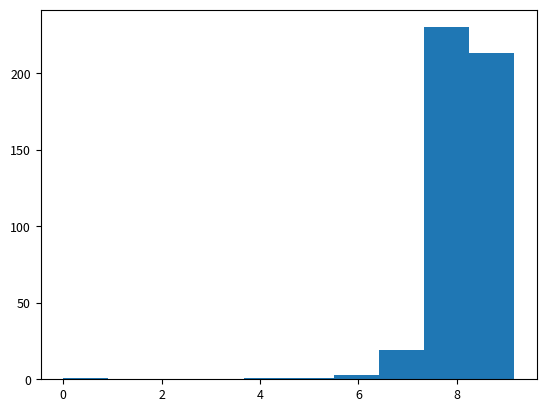

In [175]:
plt.hist(utils.reflect_log(data[MS_patients]['THALAMUS_1']))

(array([  3.,  14.,  15.,  21.,  60., 100., 122.,  90.,  33.,  10.]),
 array([ 3308.531738 ,  4260.1874997,  5211.8432614,  6163.4990231,
         7115.1547848,  8066.8105465,  9018.4663082,  9970.1220699,
        10921.7778316, 11873.4335933, 12825.089355 ]),
 <BarContainer object of 10 artists>)

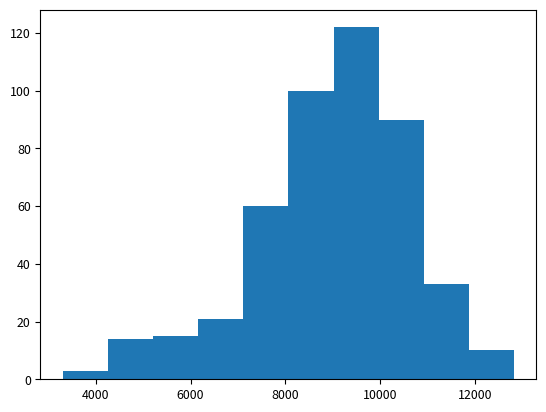

In [180]:
plt.hist(data[MS_patients]['THALAMUS_1'])

In [160]:
model_data = zscore(data[MS_patients], skip_vars=["PRL"])
outcome = "CCR2_log"

formulas = {
    "CP": f"{outcome} ~ CP",
    "T2LV": f"{outcome} ~ t2lv_log",
    "CP + T2LV": f"{outcome} ~ t2lv_log + CP",
    "CP*T2LV": f"{outcome} ~ CP*t2lv_log",
}
covariates = ["age", "Female", "tiv"]

results, models, formulas = regutils.run_regressions_from_formulas(
    model_data,
    formulas.values(),
    model_names=exog_list.keys(),
    covariates=covariates,
)

formulas

{'CP': 'CCR2_log ~ CP + age + Female + tiv',
 'T2LV': 'CCR2_log ~ t2lv_log + age + Female + tiv',
 'CP + T2LV': 'CCR2_log ~ t2lv_log + CP + age + Female + tiv'}

#### Quick mediation check

CP enlargement appeared to account for the relationship between whole brain atrophy and central CSF predominance. While brain volume alone predicted CCF (β*=-0.204, p<0.001), this association became non-significant when CP was included in the model (β*=-0.020, p=0.63), suggesting CP-associated processes mediate the central component of brain atrophy. This contrasts with T2 lesion volume, which showed independent effects alongside brain volume (both p<0.001), consistent with T2 lesions representing more diffuse pathology.

In [ ]:
p2 = Process(
    data=model_data_z,
    model=4,
    x="brain",
    y="CCR2_log",
    m=["CP"],
    controls=["age", "Female", "tiv"],
    controls_in="all",
    suppr_init=True,
)

outcome, mediation = utils.read_pyprocess_output(p2)

print("=" * 80)
print(mediation)
print("=" * 80)



Direct effect of brain on CCR2_log:

  Effect     SE       t      p    LLCI   ULCI
 -0.0220 0.0391 -0.5620 0.5744 -0.0986 0.0547

Indirect effect of brain on CCR2_log:

      Effect  Boot SE  BootLLCI  BootULCI
  CP -0.1940   0.0323   -0.2589   -0.1338




In [ ]:
p2 = Process(
    data=model_data_z,
    model=4,
    x="t2lv_log",
    y="CCR2_log",
    m=["brain"],
    controls=["age", "Female", "tiv"],
    controls_in="all",
    suppr_init=True,
)

outcome, mediation = utils.read_pyprocess_output(p2)

print("=" * 80)
print(mediation)
print("=" * 80)



Direct effect of t2lv_log on CCR2_log:

  Effect     SE      t      p   LLCI   ULCI
  0.3856 0.0395 9.7550 0.0000 0.3081 0.4631

Indirect effect of t2lv_log on CCR2_log:

         Effect  Boot SE  BootLLCI  BootULCI
  brain  0.0197   0.0092    0.0059    0.0434




### Partial Correlations

In [25]:
work_data = zscore(data[MS_patients].copy())
csf_vars = ["LV_log", "interCSF_log", "thirdV_log", "fourthV_log", "periCSF_log"]
predictors = ["CP", "t2lv_log", "THALAMUS_1", "brain"]
all_vars = csf_vars + predictors
resid_data = work_data[all_vars].copy()
covariates = ["age", "Female", "tiv"]

for var in all_vars:
    resid_data[var] = utils.residualize_structs(work_data, var, covariates)

# resid_data = resid_data.dropna()
resid_data_z = zscore(resid_data)

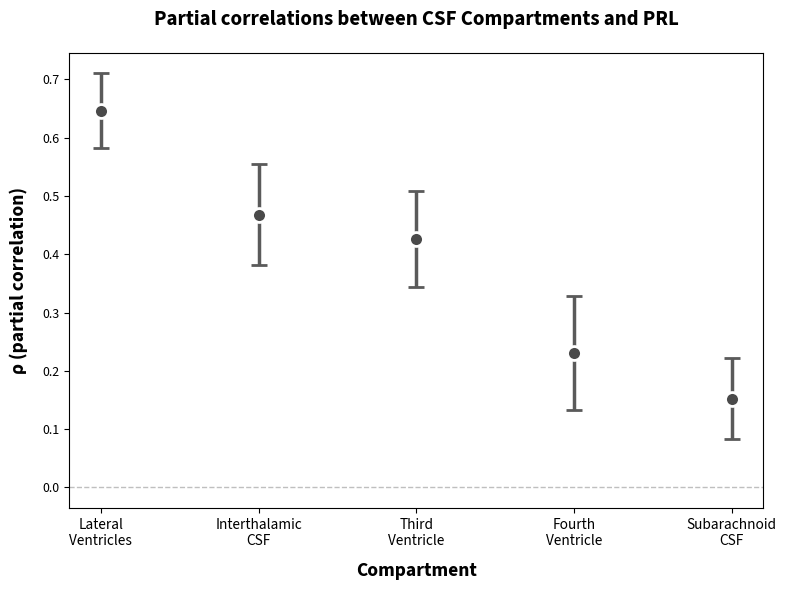

In [31]:
model_data = resid_data

csf_compartments = [
    "LV_log",
    "interCSF_log",
    "thirdV_log",
    "fourthV_log",
    "periCSF_log",
]
predictors = ["CP", "t2lv_log", "THALAMUS_1", "brain"]
covariates = None

_, results, check = regutils.run_regressions(
    model_data, csf_compartments, predictors, covariates=covariates
)

plot_data = results["CP"]
fig, ax = plot_betas(
    coefficients=plot_data['coef'],
    lower_ci=plot_data['llci'],
    upper_ci=plot_data['ulci'],
    title="Partial correlations between CSF Compartments and PRL",
    labels=['Lateral\nVentricles', 'Interthalamic\nCSF', 
            'Third\nVentricle', 'Fourth\nVentricle', 'Subarachnoid\nCSF'],
    connect_points=False,
    fig_transparent=False,
    axs_transparent=False
)

### Unstandardized Regressions

To get a sense of the scale of each compartment

In [89]:
compartments_raw = ["LV", "interCSF", "thirdV", "fourthV", "periCSF"]
compartments_log = ["LV_log", "interCSF_log", "thirdV_log", "fourthV_log", "periCSF_log"]
model_data = zscore(data[MS_patients], skip_vars=compartments_raw+compartments_log)

max_width = max(len(outcome) for outcome in compartments_raw+compartments_log)

print("Raw volumes:")
for outcome in compartments_raw:
    print(f"{outcome:<{max_width+1}}: {model_data[outcome].mean():0.2f} ± {model_data[outcome].std():0.2f}")

print("\nLog volumes:")
for outcome in compartments_log:
    print(f"{outcome:<{max_width+1}}: {model_data[outcome].mean():0.2f} ± {model_data[outcome].std():0.2f}")

Raw volumes:
LV           : 19454.91 ± 14852.40
interCSF     : 963.13 ± 347.66
thirdV       : 954.28 ± 483.20
fourthV      : 1747.36 ± 511.06
periCSF      : 344944.62 ± 34932.04

Log volumes:
LV_log       : 9.64 ± 0.69
interCSF_log : 6.81 ± 0.36
thirdV_log   : 6.74 ± 0.48
fourthV_log  : 7.43 ± 0.28
periCSF_log  : 12.75 ± 0.10


In [107]:
central_vars = ["CCR", "CCR2", "CCR_norm", "CCR2_norm", "CCR2_norm2"]
central_vars_log = [var + "_log" for var in central_vars]
model_data = zscore(data[MS_patients], skip_vars=central_vars+central_vars_log)

max_width = max(len(outcome) for outcome in central_vars+central_vars_log)

print("Raw volumes:")
for outcome in central_vars:
    print(f"{outcome:<{max_width+1}}: {model_data[outcome].mean():0.2f} ± {model_data[outcome].std():0.2f}")

print("\nLog volumes:")
for outcome in central_vars_log:
    print(f"{outcome:<{max_width+1}}: {model_data[outcome].mean():0.2f} ± {model_data[outcome].std():0.2f}")

Raw volumes:
CCR            : 0.06 ± 0.04
CCR2           : 0.06 ± 0.04
CCR_norm       : 1.02 ± 0.77
CCR2_norm      : 1.02 ± 0.75
CCR2_norm2     : 2.03 ± 1.19

Log volumes:
CCR_log        : -3.11 ± 0.67
CCR2_log       : -3.05 ± 0.65
CCR_norm_log   : -0.21 ± 0.67
CCR2_norm_log  : -0.20 ± 0.65
CCR2_norm2_log : 0.57 ± 0.52


In [133]:
compartments_raw = ["LV", "interCSF", "thirdV", "fourthV", "periCSF"]
compartments_log = ["LV_log", "interCSF_log", "thirdV_log", "fourthV_log", "periCSF_log"]
model_data = zscore(data[MS_patients], skip_vars=compartments_raw+compartments_log)

max_width = max(len(outcome) for outcome in compartments_raw+compartments_log)
display_text = ""
display_text += (f"{p}<u>Raw volumes:</u></p>")


display_volumes = [
    f"{outcome:<{max_width+1}}: {model_data[outcome].mean():0.2f} ± {model_data[outcome].std():0.2f}" for outcome in compartments_raw
]
display_text += f"{p}{'<br>'.join(display_volumes)}</p>"
# display(HTML(display_text))

# display_text = ""
display_text += (f"{p}<u>Transformed volumes:</u></p>")
display_volumes = [
    f"{outcome:<{max_width+1}}: {model_data[outcome].mean():0.2f} ± {model_data[outcome].std():0.2f}" for outcome in compartments_log
]
display_text += f"{p}{'<br>'.join(display_volumes)}</p>"
display(HTML(display_text))

Outcomes are raw values and predictors are Z-scored. Betas represent the change in mm3 of the compartment with 1SD change in the predictor

In [130]:
outcomes = compartments_raw
model_data = zscore(data[MS_patients], skip_vars=outcomes)

predictors = ["CP", "t2lv_log", "THALAMUS_1", "brain", "cortical_thickness"]
covariates = ["age", "Female", "tiv"]

results, _, check = regutils.run_regressions(
    model_data, outcomes, predictors, covariates=covariates
)

outcome_volumes = [
    f"{model_data[outcome].mean():0.2f} ± {model_data[outcome].std():0.2f}" for outcome in compartments_raw
]

# for predictor, result in results.items():
for i, outcome in enumerate(outcomes):
    result = results[outcome]
    formula = regutils.formula_string(outcome, "*predictor*", covariates)
    display_order = predictors
    display(Markdown(f"```log\n{outcome} Mean: {outcome_volumes[i]}\n```\n"))
    display(Markdown(f"```R\n{formula}\n```\n"))
    display(
        Markdown(
            regutils.present_model(
                result, cols=presentation_cols, inds=display_order
            ).to_markdown()
        )
    )

```log
LV Mean: 19454.91 ± 14852.40
```


```R
LV ~ *predictor* + age + Female + tiv
```


| predictor          |     coef |    pval |   p_fdr |      se | ci                     |   R2 |
|:-------------------|---------:|--------:|--------:|--------:|:-----------------------|-----:|
| CP                 |  6676.89 | 6.6e-32 | 1.6e-31 | 567.941 | [5.56e+03, 7.79e+03]   | 0.36 |
| t2lv_log           |  5564.44 | 4.1e-11 | 5.2e-11 | 843.167 | [3.91e+03, 7.22e+03]   | 0.33 |
| THALAMUS_1         | -9447.42 | 9.8e-41 | 4.9e-40 | 706.94  | [-1.08e+04, -8.06e+03] | 0.49 |
| brain              | -3724.4  | 1.4e-07 | 1.4e-07 | 707.827 | [-5.11e+03, -2.34e+03] | 0.25 |
| cortical_thickness | -7249.13 | 9e-20   | 1.5e-19 | 796.622 | [-8.81e+03, -5.69e+03] | 0.38 |

```log
interCSF Mean: 963.13 ± 347.66
```


```R
interCSF ~ *predictor* + age + Female + tiv
```


| predictor          |      coef |    pval |   p_fdr |      se | ci                     |   R2 |
|:-------------------|----------:|--------:|--------:|--------:|:-----------------------|-----:|
| CP                 |  151.132  | 3.5e-23 | 8.7e-23 | 15.2387 | [1.21e+02, 1.81e+02]   | 0.25 |
| t2lv_log           |  105.282  | 2.3e-06 | 2.3e-06 | 22.2947 | [61.6, 1.49e+02]       | 0.18 |
| THALAMUS_1         | -201.914  | 5.3e-33 | 2.7e-32 | 16.8732 | [-2.35e+02, -1.69e+02] | 0.33 |
| brain              |  -95.0717 | 8.3e-09 | 1e-08   | 16.4965 | [-1.27e+02, -62.7]     | 0.15 |
| cortical_thickness | -156.508  | 6.5e-17 | 1.1e-16 | 18.7285 | [-1.93e+02, -1.2e+02]  | 0.25 |

```log
thirdV Mean: 954.28 ± 483.20
```


```R
thirdV ~ *predictor* + age + Female + tiv
```


| predictor          |     coef |    pval |   p_fdr |      se | ci                     |   R2 |
|:-------------------|---------:|--------:|--------:|--------:|:-----------------------|-----:|
| CP                 |  177.303 | 1.3e-18 | 3.2e-18 | 20.1303 | [1.38e+02, 2.17e+02]   | 0.32 |
| t2lv_log           |  163.168 | 5.9e-09 | 7.4e-09 | 28.0425 | [1.08e+02, 2.18e+02]   | 0.32 |
| THALAMUS_1         | -289.721 | 7.1e-46 | 3.6e-45 | 20.3774 | [-3.3e+02, -2.5e+02]   | 0.47 |
| brain              | -126.189 | 1.4e-08 | 1.4e-08 | 22.2239 | [-1.7e+02, -82.6]      | 0.27 |
| cortical_thickness | -221.864 | 6.3e-18 | 1.1e-17 | 25.7198 | [-2.72e+02, -1.71e+02] | 0.38 |

```log
fourthV Mean: 1747.36 ± 511.06
```


```R
fourthV ~ *predictor* + age + Female + tiv
```


| predictor          |      coef |    pval |   p_fdr |      se | ci                 |   R2 |
|:-------------------|----------:|--------:|--------:|--------:|:-------------------|-----:|
| CP                 |  115.466  | 7.5e-06 | 1.9e-05 | 25.7816 | [64.9, 1.66e+02]   | 0.14 |
| t2lv_log           |   75.4819 | 0.0046  | 0.0046  | 26.6516 | [23.2, 1.28e+02]   | 0.12 |
| THALAMUS_1         | -137.516  | 1.3e-06 | 6.4e-06 | 28.3963 | [-1.93e+02, -81.9] | 0.15 |
| brain              | -108.19   | 6.3e-05 | 7.9e-05 | 27.0353 | [-1.61e+02, -55.2] | 0.13 |
| cortical_thickness | -123.825  | 1.3e-05 | 2.2e-05 | 28.435  | [-1.8e+02, -68.1]  | 0.15 |

```log
periCSF Mean: 344944.62 ± 34932.04
```


```R
periCSF ~ *predictor* + age + Female + tiv
```


| predictor          |      coef |    pval |   p_fdr |      se | ci                     |   R2 |
|:-------------------|----------:|--------:|--------:|--------:|:-----------------------|-----:|
| CP                 |   5202.74 | 2.2e-05 | 2.7e-05 | 1225.34 | [2.8e+03, 7.6e+03]     | 0.58 |
| t2lv_log           |   1680.28 | 0.2     | 0.2     | 1307.03 | [-8.81e+02, 4.24e+03]  | 0.56 |
| THALAMUS_1         |  -7085.97 | 2.4e-06 | 4e-06   | 1502.62 | [-1e+04, -4.14e+03]    | 0.59 |
| brain              |  -9543.76 | 1.8e-16 | 8.8e-16 | 1158.53 | [-1.18e+04, -7.27e+03] | 0.61 |
| cortical_thickness | -10690.8  | 2.1e-10 | 5.2e-10 | 1681.88 | [-1.4e+04, -7.39e+03]  | 0.63 |

Predictors are Z-scored but the outcomes are just log transformed. 

In [136]:
outcomes = compartments_log
model_data = zscore(data[MS_patients], skip_vars=outcomes)

predictors = ["CP", "t2lv_log", "THALAMUS_1", "brain", "cortical_thickness"]
covariates = ["age", "Female", "tiv"]

results, _, check = regutils.run_regressions(
    model_data, outcomes, predictors, covariates=covariates
)

outcome_volumes = [
    f"{model_data[outcome].mean():0.2f} ± {model_data[outcome].std():0.2f}" for outcome in compartments_log
]

# for predictor, result in results.items():
for i, outcome in enumerate(outcomes):
    result = results[outcome]
    formula = regutils.formula_string(outcome, "*predictor*", covariates)
    display_order = predictors
    display(Markdown(f"```log\n{outcome} Mean: {outcome_volumes[i]}\n```\n"))
    display(Markdown(f"```R\n{formula}\n```\n"))
    display(
        Markdown(
            regutils.present_model(
                result, cols=presentation_cols, inds=display_order
            ).to_markdown()
        )
    )

```log
LV_log Mean: 9.64 ± 0.69
```


```R
LV_log ~ *predictor* + age + Female + tiv
```


| predictor          |    coef |    pval |   p_fdr |     se | ci               |   R2 |
|:-------------------|--------:|--------:|--------:|-------:|:-----------------|-----:|
| CP                 |  0.4427 | 4.4e-85 | 2.2e-84 | 0.0226 | [0.398, 0.487]   | 0.57 |
| t2lv_log           |  0.2737 | 2.5e-13 | 3.1e-13 | 0.0374 | [0.2, 0.347]     | 0.38 |
| THALAMUS_1         | -0.4372 | 1.1e-76 | 2.9e-76 | 0.0236 | [-0.483, -0.391] | 0.53 |
| brain              | -0.1698 | 1.3e-07 | 1.3e-07 | 0.0322 | [-0.233, -0.107] | 0.28 |
| cortical_thickness | -0.3363 | 1.7e-33 | 2.9e-33 | 0.0279 | [-0.391, -0.282] | 0.42 |

```log
interCSF_log Mean: 6.81 ± 0.36
```


```R
interCSF_log ~ *predictor* + age + Female + tiv
```


| predictor          |    coef |    pval |   p_fdr |     se | ci                |   R2 |
|:-------------------|--------:|--------:|--------:|-------:|:------------------|-----:|
| CP                 |  0.1684 | 7.3e-26 | 1.8e-25 | 0.016  | [0.137, 0.2]      | 0.27 |
| t2lv_log           |  0.1007 | 1.3e-05 | 1.3e-05 | 0.0231 | [0.0554, 0.146]   | 0.17 |
| THALAMUS_1         | -0.2015 | 1.3e-41 | 6.7e-41 | 0.0149 | [-0.231, -0.172]  | 0.32 |
| brain              | -0.0981 | 1.2e-08 | 1.5e-08 | 0.0172 | [-0.132, -0.0644] | 0.15 |
| cortical_thickness | -0.1534 | 1e-19   | 1.7e-19 | 0.0169 | [-0.187, -0.12]   | 0.23 |

```log
thirdV_log Mean: 6.74 ± 0.48
```


```R
thirdV_log ~ *predictor* + age + Female + tiv
```


| predictor          |    coef |    pval |   p_fdr |     se | ci                |   R2 |
|:-------------------|--------:|--------:|--------:|-------:|:------------------|-----:|
| CP                 |  0.2064 | 7.5e-24 | 1.9e-23 | 0.0205 | [0.166, 0.247]    | 0.35 |
| t2lv_log           |  0.1603 | 7.5e-09 | 7.5e-09 | 0.0277 | [0.106, 0.215]    | 0.31 |
| THALAMUS_1         | -0.2836 | 3e-61   | 1.5e-60 | 0.0172 | [-0.317, -0.25]   | 0.45 |
| brain              | -0.1326 | 7.8e-10 | 9.8e-10 | 0.0216 | [-0.175, -0.0903] | 0.26 |
| cortical_thickness | -0.2213 | 7.5e-22 | 1.2e-21 | 0.023  | [-0.266, -0.176]  | 0.37 |

```log
fourthV_log Mean: 7.43 ± 0.28
```


```R
fourthV_log ~ *predictor* + age + Female + tiv
```


| predictor          |    coef |    pval |   p_fdr |     se | ci                 |   R2 |
|:-------------------|--------:|--------:|--------:|-------:|:-------------------|-----:|
| CP                 |  0.0632 | 4.8e-06 | 1.2e-05 | 0.0138 | [0.0361, 0.0903]   | 0.14 |
| t2lv_log           |  0.0423 | 0.0024  | 0.0024  | 0.0139 | [0.015, 0.0696]    | 0.12 |
| THALAMUS_1         | -0.0722 | 1.5e-06 | 7.6e-06 | 0.015  | [-0.102, -0.0427]  | 0.15 |
| brain              | -0.0562 | 0.00017 | 0.00021 | 0.015  | [-0.0855, -0.0269] | 0.13 |
| cortical_thickness | -0.0655 | 2.2e-05 | 3.6e-05 | 0.0154 | [-0.0958, -0.0353] | 0.14 |

```log
periCSF_log Mean: 12.75 ± 0.10
```


```R
periCSF_log ~ *predictor* + age + Female + tiv
```


| predictor          |    coef |    pval |   p_fdr |     se | ci                 |   R2 |
|:-------------------|--------:|--------:|--------:|-------:|:-------------------|-----:|
| CP                 |  0.0156 | 1.7e-05 | 2.2e-05 | 0.0036 | [0.00847, 0.0227]  | 0.57 |
| t2lv_log           |  0.0042 | 0.28    | 0.28    | 0.0039 | [-0.00339, 0.0117] | 0.55 |
| THALAMUS_1         | -0.0198 | 5.4e-06 | 9.1e-06 | 0.0044 | [-0.0283, -0.0113] | 0.58 |
| brain              | -0.0275 | 5e-16   | 2.5e-15 | 0.0034 | [-0.0342, -0.0209] | 0.61 |
| cortical_thickness | -0.0311 | 2.3e-10 | 5.8e-10 | 0.0049 | [-0.0407, -0.0215] | 0.62 |

---

## PRL Analysis

PRL count is predicted most strongly by the peripheral CSF volume. This variable has an even stronger association with PRL than CP and T2LV.

#### CSF compartment volumes predict PRL count

In [32]:
model_data = zscore(data[MS_patients], skip_vars=["PRL"])
predictors = ["LV_log", "interCSF_log", "thirdV_log", "fourthV_log", "periCSF_log"]
outcome = "PRL"

test_covariates = {
    "basic": ["age", "Female", "tiv"],
    "add CP": ["CP", "age", "Female", "tiv"],
    "add CP and t2lv": ["CP", "t2lv_log", "age", "Female", "tiv"],
}
results = {}
for model_name, covariates in test_covariates.items():
    results[model_name], _, _ = regutils.run_regressions(
        model_data, outcome, predictors, covariates=covariates, regression_model="GLM"
    )

# views = test_covariates.keys() #* all views
views = ["add CP and t2lv"]
for name in views:
    result = results[name]
    covariates = test_covariates[name]
    formula = regutils.formula_string(outcome, "*predictor*", covariates)
    display_order = result["coef"].apply(np.abs).sort_values(ascending=False).index
    display(Markdown(f"```R\n{formula}\n```\n"))
    display(
        Markdown(
            regutils.present_model(
                result, cols=presentation_cols, inds=display_order
            ).to_markdown()
        )
    )

```R
PRL ~ *predictor* + CP + t2lv_log + age + Female + tiv
```


| predictor    |   coef |    pval |   p_fdr |     se | ci               |   R2 |
|:-------------|-------:|--------:|--------:|-------:|:-----------------|-----:|
| periCSF_log  | 0.3954 | 0.00097 |  0.0048 | 0.1198 | [0.16, 0.63]     | 0.42 |
| fourthV_log  | 0.1782 | 0.034   |  0.084  | 0.0839 | [0.0138, 0.343]  | 0.39 |
| thirdV_log   | 0.1651 | 0.088   |  0.13   | 0.0969 | [-0.0248, 0.355] | 0.39 |
| interCSF_log | 0.1337 | 0.1     |  0.13   | 0.0814 | [-0.0258, 0.293] | 0.39 |
| LV_log       | 0.0522 | 0.66    |  0.66   | 0.1204 | [-0.184, 0.288]  | 0.38 |

##### Plot the betas of CSF compartments wrt to PRL

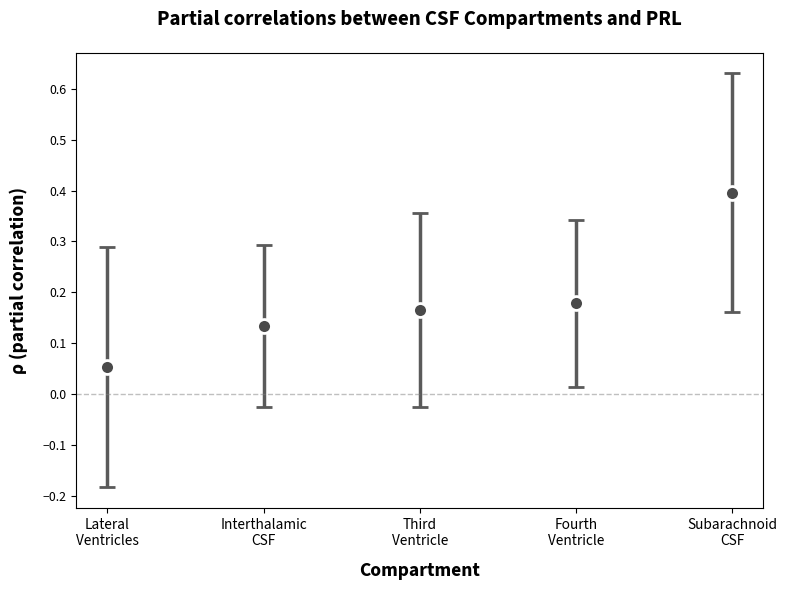

In [ ]:
plot_data = results['add CP and t2lv']
fig, ax = plot_betas(
    coefficients=plot_data['coef'],
    lower_ci=plot_data['llci'],
    upper_ci=plot_data['ulci'],
    title="Partial correlations between CSF Compartments and PRL",
    labels=['Lateral\nVentricles', 'Interthalamic\nCSF', 
            'Third\nVentricle', 'Fourth\nVentricle', 'Subarachnoid\nCSF'],
    connect_points=False,
    fig_transparent=False,
    axs_transparent=False
)

##### Explore some more models for PRL count

In [ ]:
model_data = zscore(data[MS_patients], skip_vars=["PRL"])

model_formulas = {
    "CP,t2lv,LV": "PRL ~ LV_log + CP + t2lv_log + age + Female + tiv",
    "CP,t2lv,interCSF": "PRL ~ interCSF_log + CP + t2lv_log + age + Female + tiv",
    "CP,t2lv,thirdV": "PRL ~ thirdV_log + CP + t2lv_log + age + Female + tiv",
    "CP,t2lv,fourthV": "PRL ~ fourthV_log + CP + t2lv_log + age + Female + tiv",
    "CP,t2lv,periCSF": "PRL ~ periCSF_log + CP + t2lv_log + age + Female + tiv",
    "periCSF": "PRL ~ periCSF_log + age + Female + tiv",
    "CP": "PRL ~ CP + age + Female + tiv",
    "t2lv": "PRL ~ t2lv_log + age + Female + tiv",
}

results, models, formulas = regutils.run_regressions3(
    model_data,
    model_formulas.values(),
    model_names=model_formulas.keys(),
    regression_model="GLM",
    family=sm.families.Poisson(),
)

for formula, result in zip(formulas.values(), results.values()):
    display(Markdown(f"```R\n{formula}\n```\n"))
    display(
        Markdown(
            regutils.present_model(
                result, exclude_inds=["Intercept", "age", "Female[T.1]", "tiv"]
            ).to_markdown()
        )
    )

## Analysis around MS Status

### CCR increases in MS

Is CCR specific for MS pathology? Logistic regression of MS status on CCR, controlling for age, sex, and tiv. CCR is increased in MS patients

In [ ]:
model_data = data.copy()[(MS_patients) | (NONMS_patients)]
model_data_z = zscore(model_data)
model_data_z = model_data_z.join([pd.get_dummies(model_data["dz_type2"], dtype=int)])

outcome = "MS"  # LV / allCSF
covariates = ["age", "Female", "tiv"]

predictors = {
    "CP": ["CP"],
    "LV_log": ["LV_log"],
    "CCR_log": ["CCR_log"],
    "periCSF": ["periCSF"],
    "periCSF_ratio_log": ["periCSF_ratio_log"],
}


results, models, formulas = regutils.run_regressions2(
    model_data_z,
    outcome,
    predictors.values(),
    model_names=predictors.keys(),
    covariates=covariates,
    regression_model=sm.Logit,
)

for model_name, model, formula in zip(
    results.keys(), results.values(), formulas.values()
):
    display(Markdown(f"#### {model_name}"))
    display(Markdown(f"`{formula}`"))
    display(Markdown(regutils.present_model(model, presentation_cols).to_markdown()))


# model_name = predictors[0]
# model = results[model_name]
# formula = formulas[model_name]

# display(Markdown(f"#### {model_name}"))
# display(Markdown(f"`{formula}`"))
# display(Markdown(regutils.present_model(model, presentation_cols).to_markdown()))


#### CP

`MS ~ CP + age + Female + tiv`

|           |    coef |    pval |     se | ci                |
|:----------|--------:|--------:|-------:|:------------------|
| Intercept |  1.6885 | 3.4e-45 | 0.1197 | [1.45, 1.92]      |
| CP        |  0.257  | 0.05    | 0.1311 | [0.000107, 0.514] |
| age       | -0.2702 | 0.038   | 0.1301 | [-0.525, -0.0152] |
| Female    | -0.2365 | 0.11    | 0.1473 | [-0.525, 0.0521]  |
| tiv       | -0.3618 | 0.0093  | 0.1391 | [-0.634, -0.0891] |

#### LV_log

`MS ~ LV_log + age + Female + tiv`

|           |    coef |    pval |     se | ci                 |
|:----------|--------:|--------:|-------:|:-------------------|
| Intercept |  1.6923 | 1.6e-44 | 0.1209 | [1.46, 1.93]       |
| LV_log    |  0.3332 | 0.015   | 0.137  | [0.0647, 0.602]    |
| age       | -0.327  | 0.016   | 0.1351 | [-0.592, -0.0621]  |
| Female    | -0.2866 | 0.048   | 0.1452 | [-0.571, -0.00205] |
| tiv       | -0.4573 | 0.0016  | 0.1448 | [-0.741, -0.173]   |

#### CCR_log

`MS ~ CCR_log + age + Female + tiv`

|           |    coef |    pval |     se | ci                  |
|:----------|--------:|--------:|-------:|:--------------------|
| Intercept |  1.6914 | 1.5e-44 | 0.1208 | [1.45, 1.93]        |
| CCR_log   |  0.3163 | 0.017   | 0.1326 | [0.0565, 0.576]     |
| age       | -0.315  | 0.018   | 0.1334 | [-0.576, -0.0535]   |
| Female    | -0.2852 | 0.049   | 0.145  | [-0.569, -0.000902] |
| tiv       | -0.419  | 0.003   | 0.1413 | [-0.696, -0.142]    |

#### periCSF

`MS ~ periCSF + age + Female + tiv`

|           |    coef |    pval |     se | ci                |
|:----------|--------:|--------:|-------:|:------------------|
| Intercept |  1.6633 | 3.2e-45 | 0.1179 | [1.43, 1.89]      |
| periCSF   |  0.059  | 0.74    | 0.177  | [-0.288, 0.406]   |
| age       | -0.1904 | 0.12    | 0.1229 | [-0.431, 0.0505]  |
| Female    | -0.2987 | 0.038   | 0.1438 | [-0.58, -0.0169]  |
| tiv       | -0.4055 | 0.032   | 0.1891 | [-0.776, -0.0347] |

#### periCSF_ratio_log

`MS ~ periCSF_ratio_log + age + Female + tiv`

|                   |    coef |    pval |     se | ci                  |
|:------------------|--------:|--------:|-------:|:--------------------|
| Intercept         |  1.6914 | 1.5e-44 | 0.1208 | [1.45, 1.93]        |
| periCSF_ratio_log | -0.3163 | 0.017   | 0.1326 | [-0.576, -0.0565]   |
| age               | -0.315  | 0.018   | 0.1334 | [-0.576, -0.0535]   |
| Female            | -0.2852 | 0.049   | 0.145  | [-0.569, -0.000902] |
| tiv               | -0.419  | 0.003   | 0.1413 | [-0.696, -0.142]    |

---

## Scratch

### So linters stfu about unused imports

I might want to use these ones at some point

In [ ]:
pyperclip
re
smf
stats
StringIO